In [115]:
import import_ipynb
from experiments import ResNet18Lit, prepare_data
import pytorch_lightning as pl
from pathlib import Path
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import numpy as np

In [2]:
GPUS = 1
PROJECT_PATH = '/home/maria/Documents/DL_Project'

## Loading models & data

In [4]:
dataloaders, dataset_sizes, class_names = prepare_data(
    Path(f"{PROJECT_PATH}/data/02_intermediate/sharks"))
model = ResNet18Lit.load_from_checkpoint(f'{PROJECT_PATH}/data/06_models/model-epoch=12-val_accuracy=0.71.ckpt')

## Evaluation

In [9]:
trainer = pl.Trainer(gpus=GPUS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
test_results = trainer.test(model, dataloaders["test"], verbose=True)

/home/maria/miniconda3/envs/DL_Project/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7072368264198303, 'test_loss': 0.9548888206481934}
--------------------------------------------------------------------------------


## Confusion matrix

In [52]:
def draw_confusion_matrix(model, dataloaders, mode="test"):
    labels = []
    predicted = []
    for x, y in dataloaders[mode]:
        labels.extend(y.data.detach().numpy())
        predicted.extend(list(torch.max(model(x), 1)[1].numpy()))
    cf = confusion_matrix(labels, predicted)
    df_cm = pd.DataFrame(cf, index = class_names,
                  columns = class_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

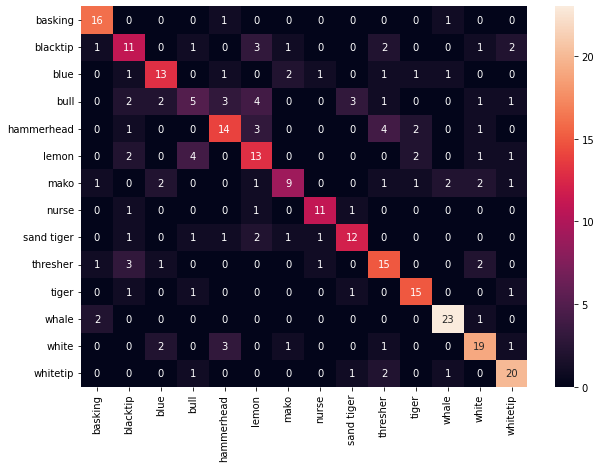

In [53]:
draw_confusion_matrix(model, dataloaders)

## Examples of incorrectly classified images

In [116]:
def draw_incorrectly_classfied_examples(model, dataloaders, class_names, mode="test"):
    
    imgs = []
    labels = []
    predicted = []
    for x, y in dataloaders[mode]:
        _, preds = torch.max(model(x), 1)
        incorrect_preds = preds != y.data
        labels.extend(y[incorrect_preds].data.detach().numpy())
        predicted.extend(list((preds[incorrect_preds]).numpy()))
        imgs.extend(x[incorrect_preds])

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            axes[i][j].imshow(np.clip(imgs[3*i + j].permute(1, 2, 0).numpy(), 0.0, 1.0))
            axes[i][j].set_xlabel(f"Correct: {class_names[labels[3*i + j]]}, predicted: {class_names[predicted[3*i + j]]}")
    plt.show()

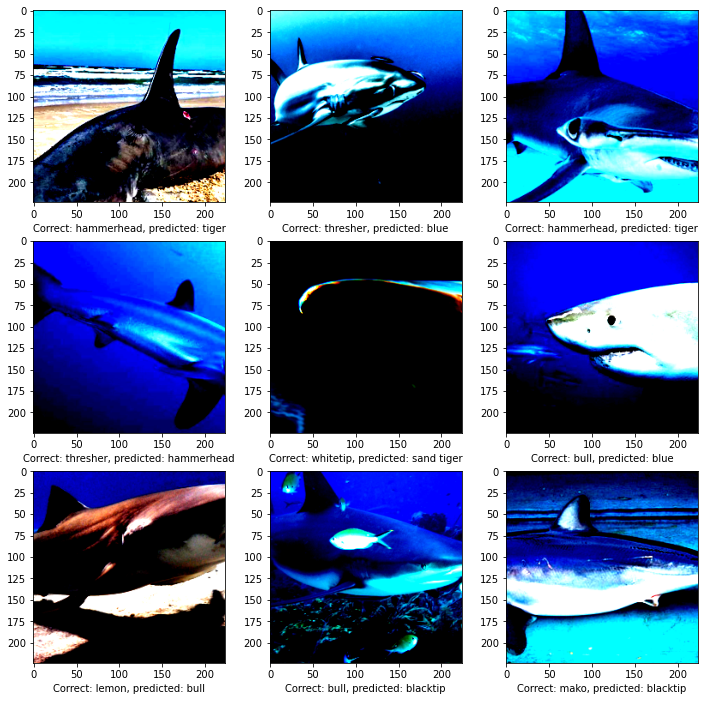

In [117]:
draw_incorrectly_classfied_examples(model, dataloaders, class_names, mode="test")